# **Model_Transfer Learning 01** - With data augmentation - Feature extraction 
Name: `Alberto Pingo` \
Email: `2202145`@my.ipleiria.pt 

Validation dataset: `train5` 

## Directories
This section sets up the directory paths used for training, validation, and test datasets based on the repository structure.

In [22]:
import os

current_dir = os.getcwd()

# TWO FOLDERS UP
data_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir, 'data'))
test_dir = os.path.join(data_dir, 'test')
train_dir = os.path.join(data_dir, 'train')

train_dirs = []
for i in range(1, 5):
    train_dirs.append(os.path.join(train_dir, 'train' + str(i)))


validation_dir = os.path.join(data_dir, 'train', 'train5')

print(current_dir)
print(data_dir)
print(test_dir)
print(train_dir)
print(validation_dir)

/home/pws/code/IA-image-classification/notebooks/models-T
/home/pws/code/IA-image-classification/data
/home/pws/code/IA-image-classification/data/test
/home/pws/code/IA-image-classification/data/train
/home/pws/code/IA-image-classification/data/train/train5


## Preprocessing
Load the datasets and perform initial preprocessing. Images are resized to 32x32 pixels and batched.

In [23]:

from keras.utils import image_dataset_from_directory
import tensorflow as tf

# Load training datasets from train1 to train4
train_datasets = []
IMG_SIZE = 150
BATCH_SIZE = 32
train_dataset = image_dataset_from_directory(train_dirs[0], image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical')
# for i in range(1, 5):
#     dataset = image_dataset_from_directory(train_dirs[i-1], image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical')
#     train_datasets.append(dataset)
 
# train_dataset = train_datasets[0]
# for dataset in train_datasets[1:]:
#     train_dataset = train_dataset.concatenate(dataset)

# Load validation dataset
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical')


# Load test dataset
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical')

class_names = validation_dataset.class_names
class_names = [class_name.split('_')[-1] for class_name in class_names]

print(class_names)

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Configure the dataset for performance

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## **Data Augmentation**
Rendom change of flipping the image horizontally. \
Random chance of moving the image horizontally and vertically [-10%, 10%].

Tried with a more complex approach to data augmentation, but the results were worse because of the small size of the images.

In [25]:
from keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.1, 0.1, fill_mode='nearest'),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.03),
])

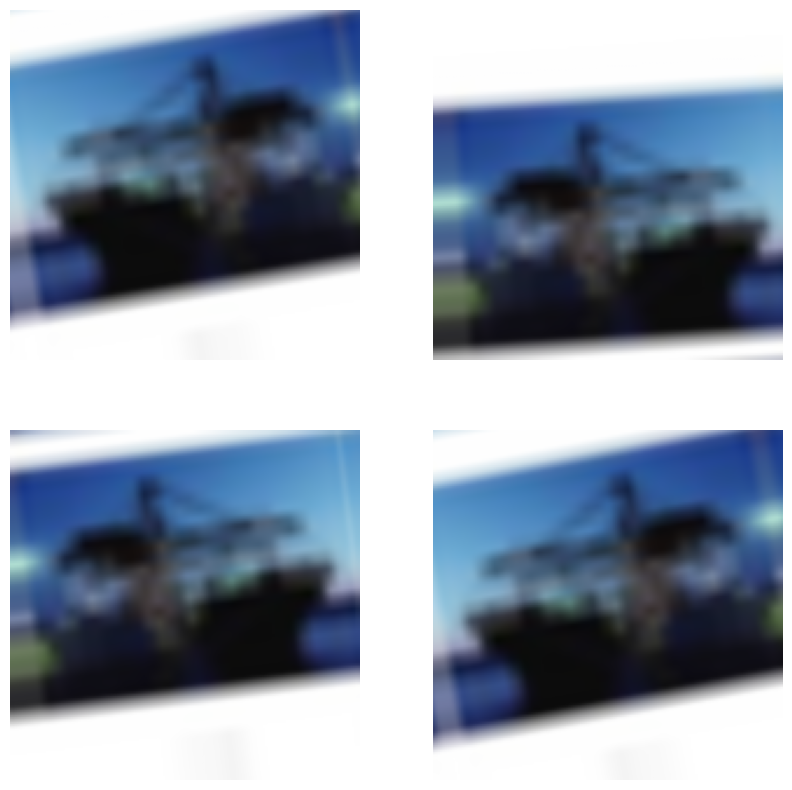

In [26]:
import matplotlib.pyplot as plt
import numpy as np

#Plot some Augmented images
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

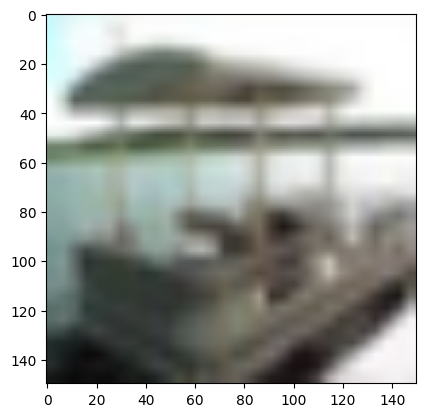

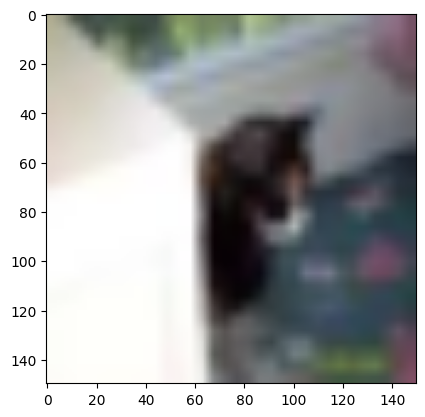

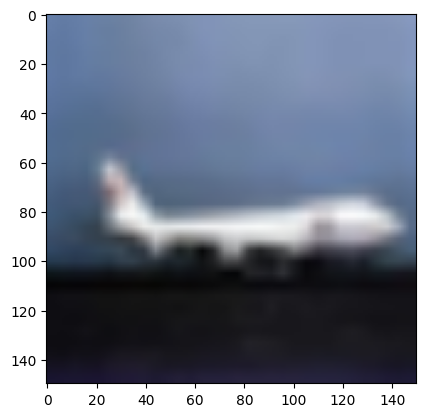

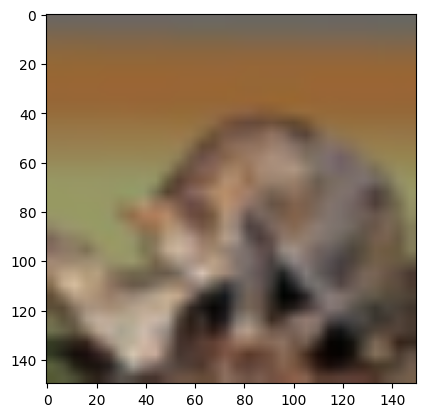

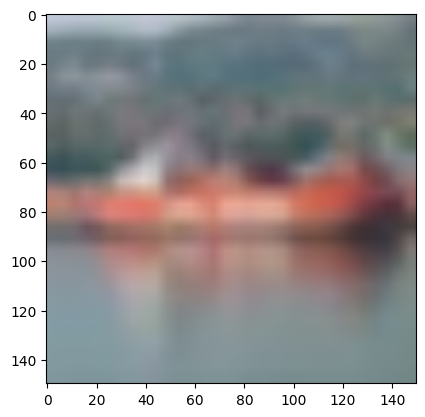

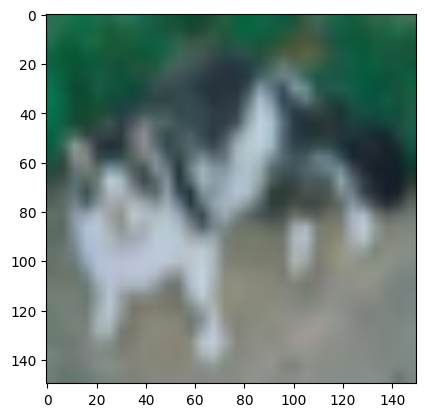

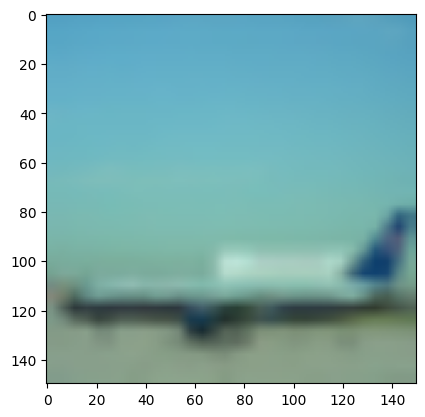

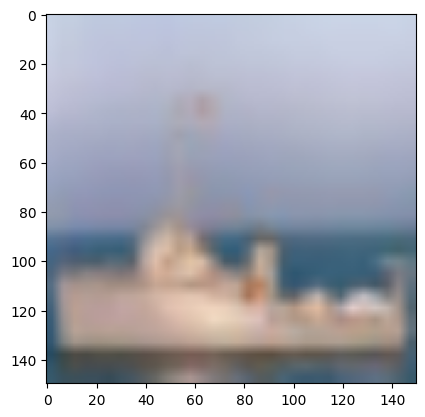

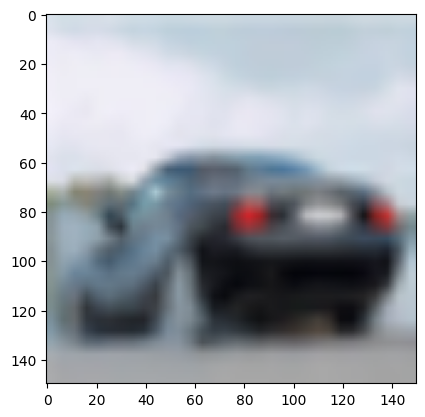

In [27]:
import matplotlib.pyplot as plt

for data, _ in train_dataset.take(1):
    for i in range(9):
        plt.imshow(data[i].numpy().astype('uint8'))
        plt.show()
    break

# **MODEL ARCHITECTURE**

## Build a Convolutional Neural Network (CNN) model.

## Transfer Learning Model

Use the VGG16 model as a base model. \
Freeze the convolutional base and train the densely connected classifier.

Data augmentation before processing the images to the model.

Use two dense layers with 256 neurons and a in-between dropout layer with a rate of 0.5.

In [28]:
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras import layers

base_model = VGG16(include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model


inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_model(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation="softmax")(x)  # Softmax for multi-class classification

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 150, 150, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0   

## Compile Model

**Loss function:** \
We use the *Categorical Crossentropy* loss function because it is a `multi-class classification` problem.

**Optimizer: Adam** \
We use the *Adam* optimizer because it is one of the best and most popular optimizers.

In [29]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc'])

## Train Model
Train the model with Early stopping, Model checkpoint, and Learning rate reduction callbacks.

In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=3, 
    verbose=1, 
    factor=0.4, 
    min_lr=1e-6)

early_stop = EarlyStopping(monitor='val_acc', 
                           patience=8,
                           restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/T01/checkpoints/T01-DA-cp.h5', save_best_only=True)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early_stop, model_checkpoint, learning_rate_reduction])

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 2.6981 - acc: 0.4071

/home/pws/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 57s 177ms/step - loss: 2.6981 - acc: 0.4071 - val_loss: 1.0745 - val_acc: 0.6791 - lr: 0.0010
Epoch 2/50
313/313 [==============================] - 55s 177ms/step - loss: 1.5151 - acc: 0.5776 - val_loss: 0.8892 - val_acc: 0.7617 - lr: 0.0010
Epoch 3/50
313/313 [==============================] - 53s 169ms/step - loss: 1.3404 - acc: 0.6067 - val_loss: 0.8123 - val_acc: 0.7691 - lr: 0.0010
Epoch 4/50
313/313 [==============================] - 53s 169ms/step - loss: 1.2438 - acc: 0.6428 - val_loss: 0.7669 - val_acc: 0.7866 - lr: 0.0010
Epoch 5/50
313/313 [==============================] - 53s 170ms/step - loss: 1.1292 - acc: 0.6721 - val_loss: 0.7313 - val_acc: 0.7917 - lr: 0.0010
Epoch 6/50
313/313 [==============================] - 52s 167ms/step - loss: 1.0273 - acc: 0.6853 - val_loss: 0.6603 - val_acc: 0.8050 - lr: 0.0010
Epoch 7/50
313/313 [==============================] - 52s 167ms/step - loss: 0.9732 - acc: 0.7094 - val_loss: 0.6268 - val_

## Save Model

In [31]:
keras.models.save_model(model, 'models/T01/T01-DA-model.h5')

/tmp/ipykernel_8035/1849881407.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, 'models/T01/T01-DA-model.h5')


In [32]:
keras.models.load_model('models/T01/T01-DA-model.h5')

# **EVALUATION**

## Evaluate the model on the validation dataset.

In [33]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

313/313 [==============================] - 29s 93ms/step - loss: 0.4452 - acc: 0.8609
val_acc: 0.8608999848365784


## Training and Validation Curves
Plot the training and validation accuracy and loss curves.

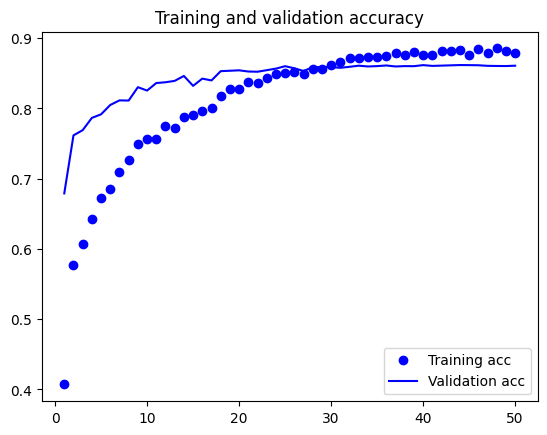

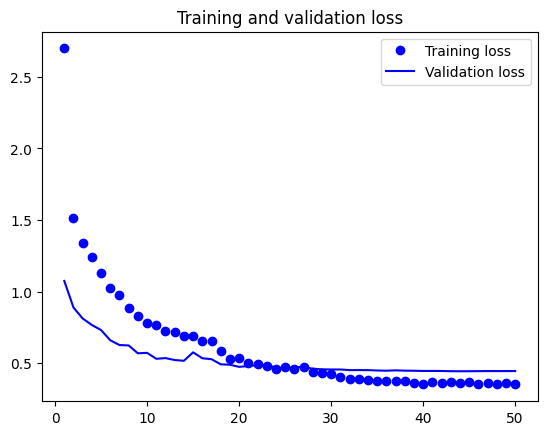

In [34]:

import matplotlib.pyplot as plt

# Extract the history from the training process
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Confusion Matrix

1/1 [==============================] - 0s 132ms/step


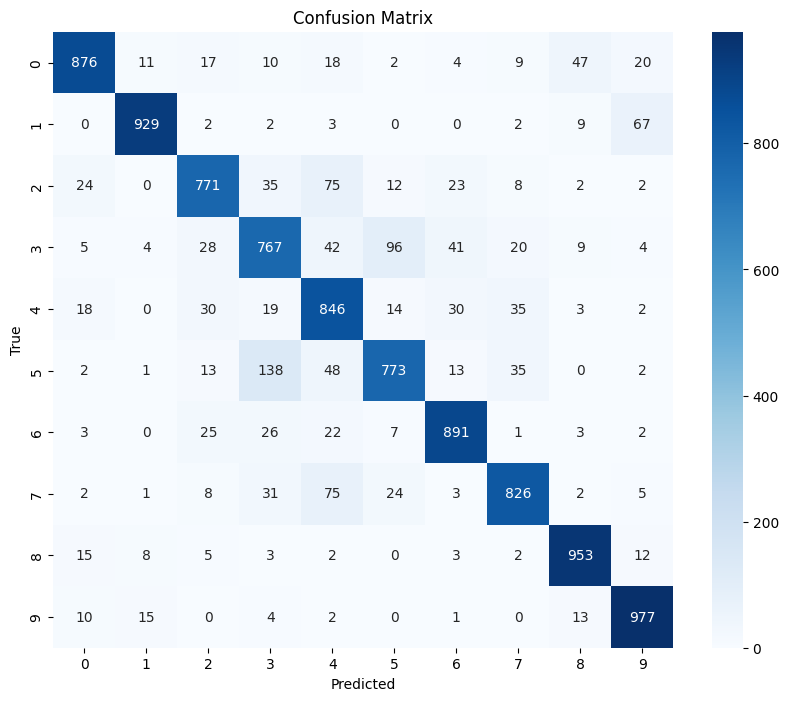

In [35]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


y_true = []
y_pred = []

for images, labels in validation_dataset:
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(model.predict(images), axis=1))
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)    

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [36]:
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[876  11  17  10  18   2   4   9  47  20]
 [  0 929   2   2   3   0   0   2   9  67]
 [ 24   0 771  35  75  12  23   8   2   2]
 [  5   4  28 767  42  96  41  20   9   4]
 [ 18   0  30  19 846  14  30  35   3   2]
 [  2   1  13 138  48 773  13  35   0   2]
 [  3   0  25  26  22   7 891   1   3   2]
 [  2   1   8  31  75  24   3 826   2   5]
 [ 15   8   5   3   2   0   3   2 953  12]
 [ 10  15   0   4   2   0   1   0  13 977]]


In [37]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.92      0.86      0.89      1014
  automobile       0.96      0.92      0.94      1014
        bird       0.86      0.81      0.83       952
         cat       0.74      0.75      0.75      1016
        deer       0.75      0.85      0.79       997
         dog       0.83      0.75      0.79      1025
        frog       0.88      0.91      0.90       980
       horse       0.88      0.85      0.86       977
        ship       0.92      0.95      0.93      1003
       truck       0.89      0.96      0.92      1022

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## Predictions

Predict and visualize the results for a sample image.

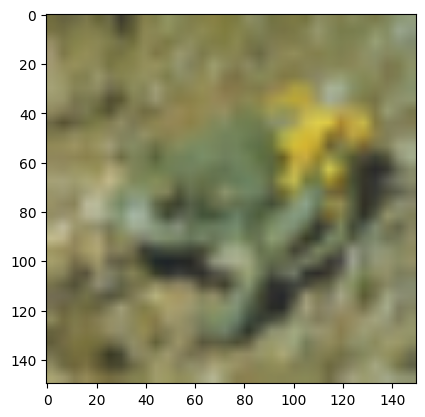

(1, 150, 150, 3)
1/1 [==============================] - 0s 29ms/step
Result:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Predicted class:  frog
True class:  frog


In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Load an image
img_path = train_dirs[0] + '/006_frog/alytes_obstetricans_s_000179.png'
# img_path2 = train_dirs[0] + '/000_airplane/airbus_s_000012.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150), interpolation='bilinear')

# Preprocess the image
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

plt.imshow(img)
plt.show()

print(img_array.shape)
result = model.predict(img_array)
print("Result: ", result.round())
print("Predicted class: ", class_names[np.argmax(result)])
print("True class: ", img_path.split('/')[-2].split('_')[-1])